<a href="https://colab.research.google.com/github/timoti1/T-SQL/blob/master/Data%20Analysis/CNN_count_ships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image
%matplotlib inline

**Seacombat Logic**

Набор функций для генерации расстановок 

In [0]:
import random
import numpy as np

def are_ships_crossed(ship1, ship2):
    ship1_set = get_ship_with_area_around(ship1)
    ship2_set = get_ship_with_area_around(ship2)
    common_set = ship1_set & ship2_set
    if len(common_set) > 0:
        if len(ship1 & common_set) > 0 or len(ship2 & common_set) > 0:
            return True
    return False


def can_place_ship(row, column, direction, size, field):
    list_of_ships = []
    ship1 = get_ship(row, column, direction, size)

    wrong_decks = [deck for deck in ship1 if
                   deck[0] > 10 or deck[0] < 1 or deck[1] > 10 or deck[1] < 1]
    if len(wrong_decks) > 0:
        return False

    for i in field:
        list_of_ships.extend(field[i])

    for ship2 in list_of_ships:
        if are_ships_crossed(ship1, ship2):
            return False

    return True


def get_arranged_ships(requirements=None):
    if not requirements:
        requirements = {4: 1, 3: 2, 2: 3, 1: 4}

    field = {key: [] for key in requirements}
    for size in requirements.keys():
        quantity = requirements[size]
        while quantity > 0:
            row = random.randint(1, 10)
            column = random.randint(1, 10)
            direction = random.randint(0, 1)  # 0 - vertical, 1 - horizontal

            if can_place_ship(row, column, direction, size, field):
                place_ship(row, column, direction, size, field)
                quantity = quantity - 1
            elif can_place_ship(row, column, 1 - direction, size, field):
                place_ship(row, column, 1 - direction, size, field)
                quantity = quantity - 1
            else:
                continue
        size = size - 1

    return field


def get_field_as_matrix(field):
    matrix = np.zeros((10, 10)).astype(np.int)

    for ship_size in field:
        for ship in field[ship_size]:
            for deck in ship:
                matrix[deck[0]-1, deck[1]-1] = 1

    return matrix


def get_test_field():
    field = {
        1: [{(3, 6)}, {(5, 9)}, {(3, 4)}, {(1, 3)}],
        2: [{(7, 10), (7, 9)}, {(7, 4), (7, 5)},
            {(10, 7), (9, 7)}],
        3: [{(1, 9), (3, 9), (2, 9)},
            {(10, 4), (10, 3), (10, 2)}],
        4: [{(5, 4), (5, 1), (5, 2), (5, 3)}]
    }
    return field


def get_ship(row, column, direction, size):
    coord_set = set()
    if direction == 1:
        for n in range(size):
            deck = row, column + n
            coord_set.add(deck)
    elif direction == 0:
        for n in range(size):
            deck = row + n, column
            coord_set.add(deck)
    return coord_set


def get_ship_with_area_around(ship):
    surrounded_ship = set()
    for deck in ship:
        temp_set = set()
        for r in range(deck[0] - 1, deck[0] + 2):
            for c in range(deck[1] - 1, deck[1] + 2):
                temp_set.add((r, c))
        surrounded_ship = surrounded_ship | temp_set
    return surrounded_ship


def place_ship(row, column, direction, size, field):
    ship = get_ship(row, column, direction, size)
    field[size].append(ship)



**Основной код**

In [0]:
# вспомогательная функция для разметки данных (прообраз того что делает слой свертки)
def apply_filter(matrix, filter, treshold):
  h, w = matrix.shape
  metrics = np.zeros(h*w).astype(np.int)
  
  fh, fw = filter.shape
  for i in range(h):
    for j in range(w):
      s = 0
      for fi in range(fh):
        for fj in range(fw):
          s +=matrix[i+fi-1,j+fj-1]*filter[fi,fj] if 0<=i+fi-1<10 and 0<=j+fj-1<10 else 0
      
      metrics[i*w+j] = s if s>=treshold else 0 #relu со смещением в сторону на treshold
  
  return metrics

In [0]:
# функция для генерации наблюдений и их разметки (X и Y)

def get_random_matrix_and_metrics(verbose=False):
  def filter(n,m):
    matrix = np.ones((n,m)).astype(np.int)
    for i in range(n):
      matrix[i,0] = -999
      matrix[i,m-1] = -999
    for i in range(m):
      matrix[0,i] = -999
      matrix[n-1,i] = -999

    return matrix
  
  # бросаем монетку. корректная ли или не обязательно будет расстановка
  rnd_num = random.randint(0, 1)

  # генерируем 1..4 кораблей длиной 4..1
  if rnd_num == 1:
    # тут генерируется корректная расстановка
    
    sum_fields = get_arranged_ships({4:1, 3:2, 2:3, 1:4})
  else:
    # тут корабли могут пересекаться
    
    sum_fields = {}
  
    for i in range(1,5):
      field = get_arranged_ships({i:5-i})       # <==== {size:cnt}

      for key in field:
        for ship in field[key]:
          if key not in sum_fields:
            sum_fields[key] = []
          if ship not in sum_fields[key]:
            sum_fields[key].append(ship)

  #       if verbose:
  #         print(f"Корабль № {i+1}: {field}")

  matrix = get_field_as_matrix(sum_fields) #| get_default_matrix()
  
#   filter3x3 = np.array([[-999,-999,-999],[-999,1,-999],[-999,-999,-999]])
  
  metrics3x3 = apply_filter(matrix, filter(3, 3), 1)
  metrics3x4 = -apply_filter(matrix, filter(3, 4), 2)
  metrics4x3 = apply_filter(matrix, filter(4, 3), 2)
  metrics3x5 = -apply_filter(matrix, filter(3, 5), 3)
  metrics5x3 = apply_filter(matrix, filter(5, 3), 3)
  metrics3x6 = -apply_filter(matrix, filter(3, 6), 4)
  metrics6x3 = apply_filter(matrix, filter(6, 3), 4)
  
  metrics = metrics3x3 + \
            metrics3x4 + metrics4x3 + \
            metrics3x5 + metrics5x3 + \
            metrics3x6 + metrics6x3 

  if verbose:
    print(f"\nПоле: \n{matrix}\n")
    print(f"Метрики: \n{metrics.reshape(10,10)}")
  
  return matrix, metrics

In [12]:
get_random_matrix_and_metrics(verbose=True);


Поле: 
[[0 0 0 0 0 0 1 1 1 0]
 [0 1 0 0 0 0 1 0 0 1]
 [0 0 0 1 0 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0]]

Метрики: 
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -4  0  0  0  0]]


In [13]:
# генерация набора данных

import numpy as np
import random

NUM_SAMPLES = 10000
batch_size = NUM_SAMPLES // 10

X = np.zeros((NUM_SAMPLES, 10, 10)).astype(np.int)
Y = np.zeros((NUM_SAMPLES, 100)).astype(np.int)

print('Генерация данных')

for i in range(NUM_SAMPLES):
  X[i], Y[i] = get_random_matrix_and_metrics()
  if i%batch_size == 0:
     print(f'\t Прогресс: {i//batch_size*10}%')
      
print('Завершено!')

Генерация данных
	 Прогресс: 0%
	 Прогресс: 10%
	 Прогресс: 20%
	 Прогресс: 30%
	 Прогресс: 40%
	 Прогресс: 50%
	 Прогресс: 60%
	 Прогресс: 70%
	 Прогресс: 80%
	 Прогресс: 90%
Завершено!


In [0]:
# from keras.utils import np_utils
# from sklearn.model_selection import train_test_split

# X = np.expand_dims(X, axis=3)
# X = X.reshape(NUM_SAMPLES, 100)

# Количество классов целевой переменной
# nb_classes = 100
# Преобразуем метки в категории
# np_utils.to_categorical

Y1 = np.where(Y==1, 1, 0)
Y2v = np.where(Y==2, 1, 0)
Y3v = np.where(Y==3, 1, 0)
Y4v = np.where(Y==4, 1, 0)
Y2h = np.where(Y==-2, 1, 0)
Y3h = np.where(Y==-3, 1, 0)
Y4h = np.where(Y==-4, 1, 0)

# # разделяем данные на тестовую и тренировочную выборки:
# x_train, x_test, y_train, y_test = train_test_split(X, Y_counts, test_size=0.25, random_state=1)

**Первая попытка создать CNN**

In [0]:
import numpy

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Activation, Concatenate, Add
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD
from keras import layers, initializers

# Задаем seed для повторяемости результатов
numpy.random.seed(33)

layer_input = Input(shape=(10,10,1), name='input')

# ветвь со слоем свертки 6х6
layer_conv_4 = Conv2D(4, (6, 6), padding='same', activation='relu', name='conv_4')(layer_input)
layer_flatten_4 = Flatten(name='flatten_4')(layer_conv_4)
layer_dense_4 = Dense(1, activation='linear', name='dense_4')(layer_flatten_4)

# ветвь со слоем свертки 5х5
layer_conv_3 = Conv2D(4, (5, 5), padding='same', activation='relu', name='conv_3')(layer_input)
layer_flatten_3 = Flatten(name='flatten_3')(layer_conv_3)
layer_dense_3 = Dense(1, activation='linear', name='dense_3')(layer_flatten_3)

# ветвь со слоем свертки 4х4
layer_conv_2 = Conv2D(2, (4, 4), padding='same', activation='relu', name='conv_2')(layer_input)
layer_flatten_2 = Flatten(name='flatten_2')(layer_conv_2)
layer_dense_2 = Dense(1, activation='linear', name='dense_2')(layer_flatten_2)

# ветвь со слоем свертки 3х3
layer_conv_1 = Conv2D(1, (3, 3), padding='same', activation='relu', name='conv_1')(layer_input)
layer_flatten_1 = Flatten(name='flatten_1')(layer_conv_1)
layer_dense_1 = Dense(1, activation='linear', name='dense_1')(layer_flatten_1)

# соединяем ветви со светочными слоями
# layer_add = Add(name='add')([layer_dense_1, layer_dense_2, layer_dense_3, layer_dense_4])
# layer_dropout = Dropout(0.75, name='final_dropout')(layer_concatenate)

# out = keras.layers.Dense(4)(added)
model_count_ships = Model(inputs=[layer_input], outputs=[layer_dense_1, layer_dense_2, layer_dense_3, layer_dense_4])

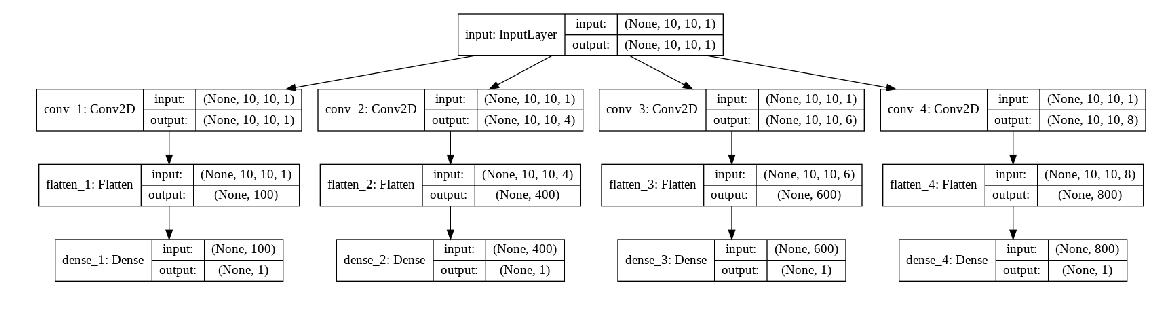

In [0]:
# сохранение графа модели в png-файл

from keras.utils import plot_model
plot_model(model_count_ships, show_shapes=True, to_file='model1.png')

im = image.load_img('model1.png')
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(im);

# model_count_ships.summary()

In [0]:
# класс для колбак-функции, вызываемой в процессе обучения модели
import keras

class PlotConvCallBack(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        
#     def on_train_end(self, logs={}):
#         return

    def on_epoch_begin(self, epoch, logs={}):
        if epoch%10 != 0:
          return
      
        fig, ax = plt.subplots(4, 8)
    
        for i in range(4):
          for j in range(8):
            ax[i, j].axis('off') 

        for i, layer_name in enumerate(['conv_1', 'conv_2', 'conv_3', 'conv_4']):
          conv_layer = self.model.get_layer(layer_name)
          conv_layer_shape = conv_layer.get_config()['kernel_size']
          num_filters = conv_layer.get_config()['filters']

          for j in range(num_filters):
            conv_weight_tensor = conv_layer.get_weights()[0][:,:,:,j]
            ax[i, j].imshow(conv_weight_tensor.reshape(conv_layer_shape))
        plt.show()
            
    def on_epoch_end(self, epoch, logs={}):
        if epoch%10 != 0:
            return

        for k, v in logs.items():
            if k.find('val_') == -1:
                print(f'\t{k}:\t{v:9.5}')
        
#     def on_batch_begin(self, batch, logs={}):
#       return

#     def on_batch_end(self, batch, logs={}):
#       return

Train on 9000 samples, validate on 1000 samples
Epoch 1/100


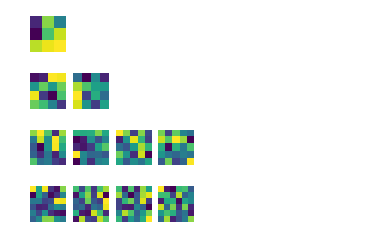

 - 13s - loss: 137645017.0933 - dense_1_loss: 1.7715 - dense_2_loss: 100592080.6133 - dense_3_loss: 32525816.9556 - dense_4_loss: 4527119.5176 - val_loss: 95625288.9600 - val_dense_1_loss: 1.4170 - val_dense_2_loss: 83001629.7600 - val_dense_3_loss: 12472325.9900 - val_dense_4_loss: 151332.9602
	loss:	1.3765e+08
	dense_1_loss:	   1.7715
	dense_2_loss:	1.0059e+08
	dense_3_loss:	3.2526e+07
	dense_4_loss:	4.5271e+06
Epoch 2/100
 - 4s - loss: 61770624.9222 - dense_1_loss: 1.2688 - dense_2_loss: 58386256.7800 - dense_3_loss: 3330911.4695 - dense_4_loss: 53456.5172 - val_loss: 34964856.8200 - val_dense_1_loss: 1.2032 - val_dense_2_loss: 34671310.3800 - val_dense_3_loss: 247296.0830 - val_dense_4_loss: 46250.0101
Epoch 3/100
 - 4s - loss: 18373028.3478 - dense_1_loss: 1.1172 - dense_2_loss: 18147789.8033 - dense_3_loss: 182740.0183 - dense_4_loss: 42497.3942 - val_loss: 6680732.9000 - val_dense_1_loss: 1.0822 - val_dense_2_loss: 6451574.3550 - val_dense_3_loss: 185751.0838 - val_dense_4_loss:

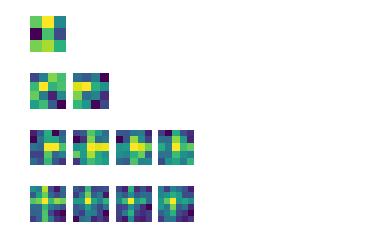

 - 5s - loss: 370894.2702 - dense_1_loss: 0.6327 - dense_2_loss: 257606.6701 - dense_3_loss: 96448.0849 - dense_4_loss: 16838.8822 - val_loss: 381829.8249 - val_dense_1_loss: 0.6691 - val_dense_2_loss: 265085.1332 - val_dense_3_loss: 99772.5214 - val_dense_4_loss: 16971.5040
	loss:	3.7089e+05
	dense_1_loss:	   0.6327
	dense_2_loss:	2.5761e+05
	dense_3_loss:	9.6448e+04
	dense_4_loss:	1.6839e+04
Epoch 12/100
 - 4s - loss: 347084.4406 - dense_1_loss: 0.6194 - dense_2_loss: 241193.9347 - dense_3_loss: 90319.0220 - dense_4_loss: 15570.8645 - val_loss: 357958.2288 - val_dense_1_loss: 0.6653 - val_dense_2_loss: 248565.4746 - val_dense_3_loss: 93745.3403 - val_dense_4_loss: 15646.7513
Epoch 13/100
 - 4s - loss: 325202.1455 - dense_1_loss: 0.6101 - dense_2_loss: 226003.6666 - dense_3_loss: 84824.8609 - dense_4_loss: 14373.0079 - val_loss: 336435.7241 - val_dense_1_loss: 0.6581 - val_dense_2_loss: 233798.5039 - val_dense_3_loss: 88210.1350 - val_dense_4_loss: 14426.4305
Epoch 14/100
 - 4s - loss

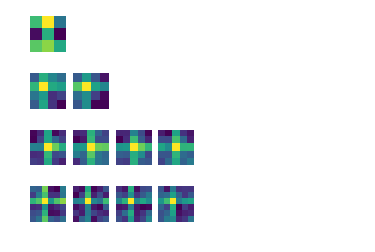

 - 5s - loss: 200224.9636 - dense_1_loss: 0.5786 - dense_2_loss: 146412.6739 - dense_3_loss: 47708.2753 - dense_4_loss: 6103.4353 - val_loss: 207048.0491 - val_dense_1_loss: 0.6581 - val_dense_2_loss: 152605.5898 - val_dense_3_loss: 48591.6218 - val_dense_4_loss: 5850.1792
	loss:	2.0022e+05
	dense_1_loss:	  0.57859
	dense_2_loss:	1.4641e+05
	dense_3_loss:	4.7708e+04
	dense_4_loss:	   6103.4
Epoch 22/100
 - 4s - loss: 187728.0919 - dense_1_loss: 0.5780 - dense_2_loss: 139096.7697 - dense_3_loss: 43401.5564 - dense_4_loss: 5229.1876 - val_loss: 193540.4278 - val_dense_1_loss: 0.6434 - val_dense_2_loss: 144693.2355 - val_dense_3_loss: 43894.7942 - val_dense_4_loss: 4951.7551
Epoch 23/100
 - 4s - loss: 175551.8920 - dense_1_loss: 0.5744 - dense_2_loss: 132032.6260 - dense_3_loss: 39138.4037 - dense_4_loss: 4380.2883 - val_loss: 180880.8476 - val_dense_1_loss: 0.6390 - val_dense_2_loss: 137391.5429 - val_dense_3_loss: 39388.0132 - val_dense_4_loss: 4100.6522
Epoch 24/100
 - 4s - loss: 16353

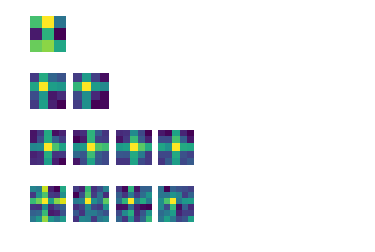

 - 5s - loss: 100644.4641 - dense_1_loss: 0.5692 - dense_2_loss: 87159.7530 - dense_3_loss: 13146.7444 - dense_4_loss: 337.3974 - val_loss: 102266.5640 - val_dense_1_loss: 0.6384 - val_dense_2_loss: 89511.0333 - val_dense_3_loss: 12474.5874 - val_dense_4_loss: 280.3040
	loss:	1.0064e+05
	dense_1_loss:	  0.56923
	dense_2_loss:	8.716e+04
	dense_3_loss:	1.3147e+04
	dense_4_loss:	    337.4
Epoch 32/100
 - 4s - loss: 93634.4247 - dense_1_loss: 0.5689 - dense_2_loss: 82408.4870 - dense_3_loss: 11026.3094 - dense_4_loss: 199.0593 - val_loss: 94955.2186 - val_dense_1_loss: 0.6357 - val_dense_2_loss: 84427.8926 - val_dense_3_loss: 10370.5187 - val_dense_4_loss: 156.1715
Epoch 33/100
 - 4s - loss: 87372.4491 - dense_1_loss: 0.5686 - dense_2_loss: 78076.1294 - dense_3_loss: 9185.5668 - dense_4_loss: 110.1842 - val_loss: 88289.8173 - val_dense_1_loss: 0.6342 - val_dense_2_loss: 79610.9296 - val_dense_3_loss: 8601.7569 - val_dense_4_loss: 76.4965
Epoch 34/100
 - 4s - loss: 81270.3756 - dense_1_loss

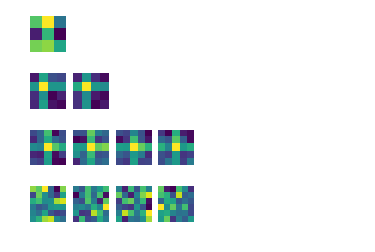

 - 5s - loss: 49875.3201 - dense_1_loss: 0.5650 - dense_2_loss: 48601.0454 - dense_3_loss: 1272.8014 - dense_4_loss: 0.9082 - val_loss: 49852.1338 - val_dense_1_loss: 0.6346 - val_dense_2_loss: 48790.3584 - val_dense_3_loss: 1060.5932 - val_dense_4_loss: 0.5476
	loss:	4.9875e+04
	dense_1_loss:	  0.56499
	dense_2_loss:	4.8601e+04
	dense_3_loss:	   1272.8
	dense_4_loss:	  0.90815
Epoch 42/100
 - 4s - loss: 46393.1091 - dense_1_loss: 0.5650 - dense_2_loss: 45482.4430 - dense_3_loss: 909.3313 - dense_4_loss: 0.7697 - val_loss: 46404.9829 - val_dense_1_loss: 0.6385 - val_dense_2_loss: 45661.9345 - val_dense_3_loss: 741.8227 - val_dense_4_loss: 0.5872
Epoch 43/100
 - 4s - loss: 43219.1804 - dense_1_loss: 0.5658 - dense_2_loss: 42596.9577 - dense_3_loss: 620.9975 - dense_4_loss: 0.6593 - val_loss: 42636.3582 - val_dense_1_loss: 0.6342 - val_dense_2_loss: 42145.4835 - val_dense_3_loss: 489.8562 - val_dense_4_loss: 0.3844
Epoch 44/100
 - 4s - loss: 40052.2605 - dense_1_loss: 0.5654 - dense_2_lo

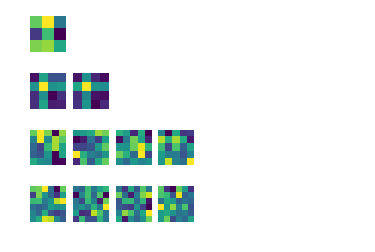

 - 5s - loss: 22159.4045 - dense_1_loss: 0.5605 - dense_2_loss: 22154.8215 - dense_3_loss: 3.5768 - dense_4_loss: 0.4458 - val_loss: 21196.2012 - val_dense_1_loss: 0.6361 - val_dense_2_loss: 21192.8873 - val_dense_3_loss: 2.3370 - val_dense_4_loss: 0.3409
	loss:	2.2159e+04
	dense_1_loss:	  0.56053
	dense_2_loss:	2.2155e+04
	dense_3_loss:	   3.5768
	dense_4_loss:	  0.44576
Epoch 52/100
 - 4s - loss: 19999.5971 - dense_1_loss: 0.5627 - dense_2_loss: 19995.7277 - dense_3_loss: 2.8530 - dense_4_loss: 0.4536 - val_loss: 19449.9460 - val_dense_1_loss: 0.6299 - val_dense_2_loss: 19446.5329 - val_dense_3_loss: 2.3857 - val_dense_4_loss: 0.3975
Epoch 53/100
 - 4s - loss: 17972.9070 - dense_1_loss: 0.5603 - dense_2_loss: 17969.4425 - dense_3_loss: 2.4784 - dense_4_loss: 0.4257 - val_loss: 16960.7432 - val_dense_1_loss: 0.6312 - val_dense_2_loss: 16956.8472 - val_dense_3_loss: 2.9564 - val_dense_4_loss: 0.3084
Epoch 54/100
 - 4s - loss: 16047.4630 - dense_1_loss: 0.5614 - dense_2_loss: 16044.3045

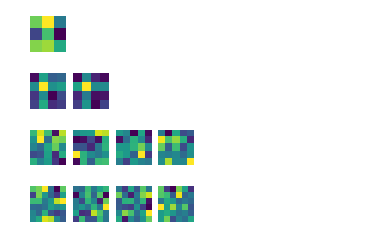

 - 5s - loss: 6054.1427 - dense_1_loss: 0.5598 - dense_2_loss: 6051.9725 - dense_3_loss: 1.1889 - dense_4_loss: 0.4215 - val_loss: 5371.4783 - val_dense_1_loss: 0.6290 - val_dense_2_loss: 5369.8293 - val_dense_3_loss: 0.7860 - val_dense_4_loss: 0.2340
	loss:	   6054.1
	dense_1_loss:	  0.55982
	dense_2_loss:	   6052.0
	dense_3_loss:	   1.1889
	dense_4_loss:	  0.42155
Epoch 62/100
 - 4s - loss: 5053.2120 - dense_1_loss: 0.5586 - dense_2_loss: 5051.1384 - dense_3_loss: 1.0734 - dense_4_loss: 0.4416 - val_loss: 4439.2112 - val_dense_1_loss: 0.6376 - val_dense_2_loss: 4436.6872 - val_dense_3_loss: 1.1106 - val_dense_4_loss: 0.7758
Epoch 63/100
 - 4s - loss: 4174.5543 - dense_1_loss: 0.5586 - dense_2_loss: 4172.6319 - dense_3_loss: 0.9421 - dense_4_loss: 0.4217 - val_loss: 3640.7425 - val_dense_1_loss: 0.6318 - val_dense_2_loss: 3639.2677 - val_dense_3_loss: 0.6184 - val_dense_4_loss: 0.2246
Epoch 64/100
 - 4s - loss: 3379.0177 - dense_1_loss: 0.5594 - dense_2_loss: 3377.0483 - dense_3_loss:

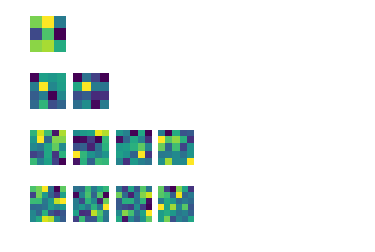

 - 5s - loss: 449.9744 - dense_1_loss: 0.5572 - dense_2_loss: 448.0158 - dense_3_loss: 0.9428 - dense_4_loss: 0.4587 - val_loss: 365.1067 - val_dense_1_loss: 0.6318 - val_dense_2_loss: 362.6977 - val_dense_3_loss: 0.7219 - val_dense_4_loss: 1.0554
	loss:	   449.97
	dense_1_loss:	   0.5572
	dense_2_loss:	   448.02
	dense_3_loss:	  0.94279
	dense_4_loss:	  0.45868
Epoch 72/100
 - 4s - loss: 291.5121 - dense_1_loss: 0.5587 - dense_2_loss: 289.6423 - dense_3_loss: 0.8823 - dense_4_loss: 0.4288 - val_loss: 211.8553 - val_dense_1_loss: 0.6238 - val_dense_2_loss: 210.3605 - val_dense_3_loss: 0.6189 - val_dense_4_loss: 0.2521
Epoch 73/100
 - 4s - loss: 177.2632 - dense_1_loss: 0.5594 - dense_2_loss: 175.3342 - dense_3_loss: 0.9615 - dense_4_loss: 0.4082 - val_loss: 132.7399 - val_dense_1_loss: 0.6228 - val_dense_2_loss: 131.3807 - val_dense_3_loss: 0.5252 - val_dense_4_loss: 0.2112
Epoch 74/100


In [0]:
# Размер мини-выборки
batch_size = 10
# Количество эпох для обучения
nb_epoch = 100

# Задаем параметры оптимизации

# sgd = SGD(lr=0.001, decay=0.001, momentum=0.9, nesterov=True)

model_count_ships.compile(loss='mse',
              optimizer='adam',
              metrics=[])

plot_conv_matrix = PlotConvCallBack()

# подсчитываем число "правильных" кораблей (задача регрессии)

# Обучаем модель
history = model_count_ships.fit(
              X.reshape(NUM_SAMPLES,10,10,1),                         
              [
                  [int(Y1[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y2h[i].sum())+int(Y2v.sum()) for i in range(NUM_SAMPLES)],
                  [int(Y3h[i].sum())+int(Y3v.sum()) for i in range(NUM_SAMPLES)],
                  [int(Y4h[i].sum())+int(Y4v.sum()) for i in range(NUM_SAMPLES)],
              ],
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              callbacks=[plot_conv_matrix],
              verbose=2)

In [0]:
# График функций точности и качества модели (потерь)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('График точности модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График качества модели')
plt.ylabel('Ошибка')
plt.xlabel('Эпоха')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Оцениваем качество обучения модели на тестовых данных
# y_counts = [int(y_test[i].sum()) for i in range(y_test.shape[0])]
# scores = model.evaluate(x_test.reshape(x_test.shape[0],10,10,1), y_counts, verbose=0)
# print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

In [0]:
# подключаем библтотеки

import numpy

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Activation, Concatenate, Add
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD
from keras import layers, initializers

In [0]:
# функция для создания модели с весами, инициализированными конкретным seed

def create_model(seed=0):
  # Задаем seed для повторяемости результатов
  numpy.random.seed(seed)

  layer_input = Input(shape=(10,10,1), name='input')

  # ветвь со слоем свертки для 4-палубников
  layer_conv_4h = Conv2D(1, (3, 6), padding='same', activation='relu', name='conv_4h')(layer_input)
  layer_conv_4v = Conv2D(1, (6, 3), padding='same', activation='relu', name='conv_4v')(layer_input)

  layer_flatten_4h = Flatten(name='flatten_4h')(layer_conv_4h)
  layer_flatten_4v = Flatten(name='flatten_4v')(layer_conv_4v)

  layer_dense_4h = Dense(1, activation='relu', name='dense_4h')(layer_flatten_4h)
  layer_dense_4v = Dense(1, activation='relu', name='dense_4v')(layer_flatten_4v)

  # ветвь со слоем свертки для 3-палубников
  layer_conv_3h = Conv2D(1, (3, 5), padding='same', activation='relu', name='conv_3h')(layer_input)
  layer_conv_3v = Conv2D(1, (5, 3), padding='same', activation='relu', name='conv_3v')(layer_input)

  layer_flatten_3h = Flatten(name='flatten_3h')(layer_conv_3h)
  layer_flatten_3v = Flatten(name='flatten_3v')(layer_conv_3v)

  layer_dense_3h = Dense(1, activation='relu', name='dense_3h')(layer_flatten_3h)
  layer_dense_3v = Dense(1, activation='relu', name='dense_3v')(layer_flatten_3v)

  # ветвь со слоем свертки для 2-палубников
  layer_conv_2h = Conv2D(1, (3, 4), padding='same', activation='relu', name='conv_2h')(layer_input)
  layer_conv_2v = Conv2D(1, (4, 3), padding='same', activation='relu', name='conv_2v')(layer_input)

  layer_flatten_2h = Flatten(name='flatten_2h')(layer_conv_2h)
  layer_flatten_2v = Flatten(name='flatten_2v')(layer_conv_2v)

  layer_dense_2h = Dense(1, activation='relu', name='dense_2h')(layer_flatten_2h)
  layer_dense_2v = Dense(1, activation='relu', name='dense_2v')(layer_flatten_2v)

  # ветвь со слоем свертки для 1-палубников
  layer_conv_1 = Conv2D(1, (3, 3), padding='same', activation='relu', name='conv_1')(layer_input)
  layer_flatten_1 = Flatten(name='flatten_1')(layer_conv_1)
  layer_dense_1 = Dense(1, activation='relu', name='dense_1')(layer_flatten_1)

  # соединяем ветви со светочными слоями
  # layer_add = Add(name='add')([layer_dense_1, layer_dense_2, layer_dense_3, layer_dense_4])
  # out = keras.layers.Dense(4)(added)

  model_custom = Model(inputs=[layer_input], outputs=[layer_dense_1, \
                                                      layer_dense_2h, layer_dense_2v, \
                                                      layer_dense_3h, layer_dense_3v, \
                                                      layer_dense_4h, layer_dense_4v
                                                     ])
  
  return model_custom

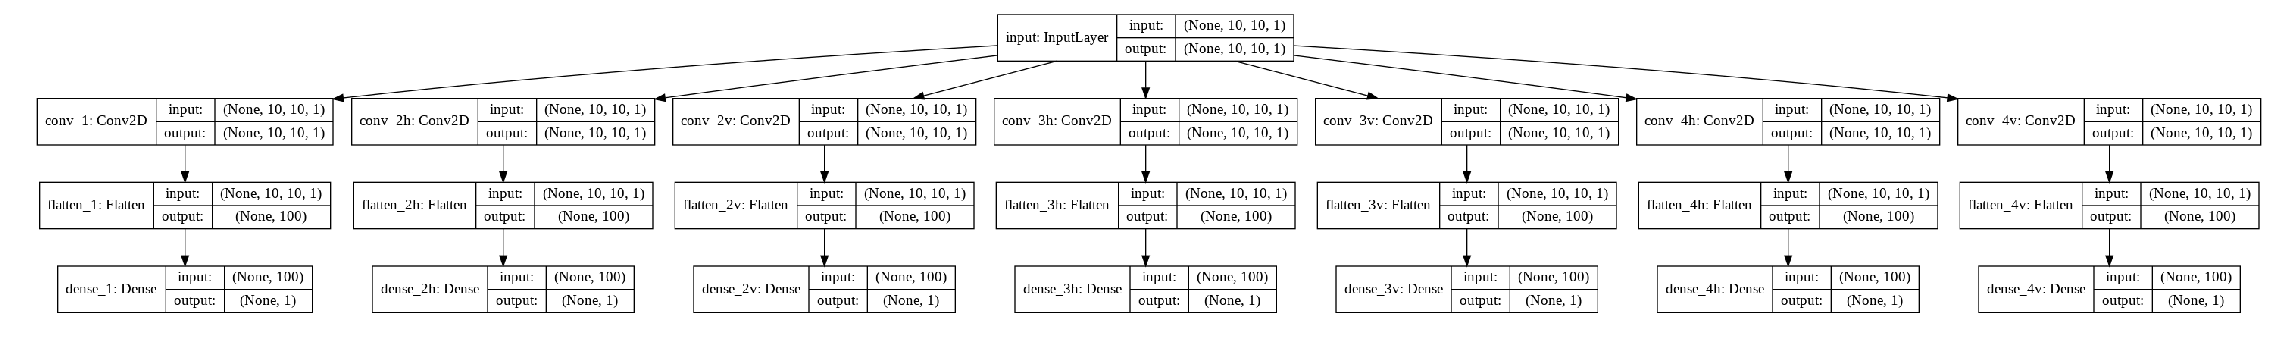

In [0]:
# сохранение графа модели в png-файл

from keras.utils import plot_model
plot_model(create_model(0), show_shapes=True, to_file='model_custom.png')

im = image.load_img('model_custom.png')
plt.figure(figsize=(40,20))
plt.axis('off')
plt.imshow(im);

# model_count_ships.summary()

In [0]:
# класс для колбак-функции, вызываемой в процессе обучения модели

import keras

class PlotConvCallBack(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    
    def on_train_end(self, logs={}):
        fig, ax = plt.subplots(4, 2)
    
        for i in range(4):
          for j in range(2):
            ax[i, j].axis('off') 

        conv_layer_names = [['conv_1'], 
                            ['conv_2h', 'conv_2v'], \
                            ['conv_3h', 'conv_3v'], \
                            ['conv_4h', 'conv_4v']]
        
        for i, layer_names in enumerate(conv_layer_names):
          for j, layer_name in enumerate(layer_names):
            conv_layer = self.model.get_layer(layer_name)
            conv_layer_shape = conv_layer.get_config()['kernel_size']

            conv_weight_tensor = conv_layer.get_weights()[0]  #[:,:,:,1]
            ax[i, j].imshow(conv_weight_tensor.reshape(conv_layer_shape))

        plt.show()

        
#     def on_epoch_begin(self, epoch, logs={}):
#         if epoch%10 != 0:
#           return
            
#     def on_epoch_end(self, epoch, logs={}):
#         if epoch%10 != 0:
#             return

#         for k, v in logs.items():
#             if k.find('val_') == -1:
#                 print(f'\t{k}:\t{v:9.5}')
        
#     def on_batch_begin(self, batch, logs={}):
#       return

#     def on_batch_end(self, batch, logs={}):
#       return


Seed = 0

Epoch 1/20
10000/10000 [==============================] - 35s 3ms/step - loss: 3.5924 - dense_1_loss: 1.2299 - dense_2h_loss: 0.6222 - dense_2v_loss: 0.5947 - dense_3h_loss: 0.4376 - dense_3v_loss: 0.3689 - dense_4h_loss: 0.1726 - dense_4v_loss: 0.1665
Epoch 2/20
10000/10000 [==============================] - 32s 3ms/step - loss: 2.7507 - dense_1_loss: 0.9291 - dense_2h_loss: 0.4921 - dense_2v_loss: 0.4417 - dense_3h_loss: 0.3357 - dense_3v_loss: 0.2934 - dense_4h_loss: 0.1305 - dense_4v_loss: 0.1280
Epoch 3/20
10000/10000 [==============================] - 32s 3ms/step - loss: 2.5203 - dense_1_loss: 0.8471 - dense_2h_loss: 0.4356 - dense_2v_loss: 0.3686 - dense_3h_loss: 0.3258 - dense_3v_loss: 0.2875 - dense_4h_loss: 0.1288 - dense_4v_loss: 0.1268
Epoch 4/20
10000/10000 [==============================] - 32s 3ms/step - loss: 2.3456 - dense_1_loss: 0.7915 - dense_2h_loss: 0.3781 - dense_2v_loss: 0.3193 - dense_3h_loss: 0.3217 - dense_3v_loss: 0.2817 - dense_4h_loss: 0.1275 -

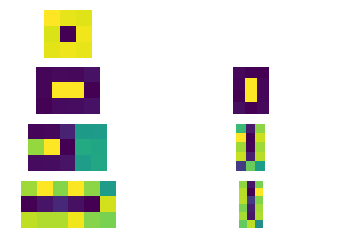


Seed = 1

Epoch 1/20
10000/10000 [==============================] - 36s 4ms/step - loss: 3.8422 - dense_1_loss: 1.2558 - dense_2h_loss: 0.5487 - dense_2v_loss: 0.6644 - dense_3h_loss: 0.4473 - dense_3v_loss: 0.4367 - dense_4h_loss: 0.1742 - dense_4v_loss: 0.3152
Epoch 2/20
10000/10000 [==============================] - 33s 3ms/step - loss: 2.6234 - dense_1_loss: 0.7169 - dense_2h_loss: 0.3603 - dense_2v_loss: 0.4891 - dense_3h_loss: 0.3311 - dense_3v_loss: 0.2800 - dense_4h_loss: 0.1307 - dense_4v_loss: 0.3152
Epoch 3/20
10000/10000 [==============================] - 33s 3ms/step - loss: 2.2400 - dense_1_loss: 0.4338 - dense_2h_loss: 0.3068 - dense_2v_loss: 0.4756 - dense_3h_loss: 0.3148 - dense_3v_loss: 0.2652 - dense_4h_loss: 0.1287 - dense_4v_loss: 0.3152
Epoch 4/20
10000/10000 [==============================] - 33s 3ms/step - loss: 2.0273 - dense_1_loss: 0.3269 - dense_2h_loss: 0.2426 - dense_2v_loss: 0.4611 - dense_3h_loss: 0.3041 - dense_3v_loss: 0.2500 - dense_4h_loss: 0.1275 -

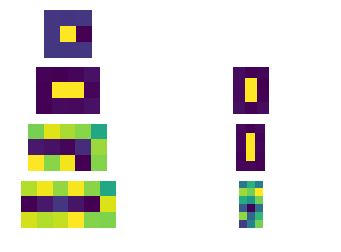


Seed = 2

Epoch 1/20
10000/10000 [==============================] - 37s 4ms/step - loss: 3.5517 - dense_1_loss: 1.2605 - dense_2h_loss: 0.6209 - dense_2v_loss: 0.6310 - dense_3h_loss: 0.3464 - dense_3v_loss: 0.3992 - dense_4h_loss: 0.1496 - dense_4v_loss: 0.1440
Epoch 2/20
10000/10000 [==============================] - 34s 3ms/step - loss: 2.4628 - dense_1_loss: 0.7551 - dense_2h_loss: 0.4363 - dense_2v_loss: 0.4967 - dense_3h_loss: 0.2657 - dense_3v_loss: 0.2778 - dense_4h_loss: 0.1145 - dense_4v_loss: 0.1167
Epoch 3/20
10000/10000 [==============================] - 33s 3ms/step - loss: 2.1689 - dense_1_loss: 0.6760 - dense_2h_loss: 0.3206 - dense_2v_loss: 0.4512 - dense_3h_loss: 0.2431 - dense_3v_loss: 0.2664 - dense_4h_loss: 0.1044 - dense_4v_loss: 0.1071
Epoch 4/20
10000/10000 [==============================] - 34s 3ms/step - loss: 2.0257 - dense_1_loss: 0.6322 - dense_2h_loss: 0.2712 - dense_2v_loss: 0.4347 - dense_3h_loss: 0.2247 - dense_3v_loss: 0.2636 - dense_4h_loss: 0.0987 -

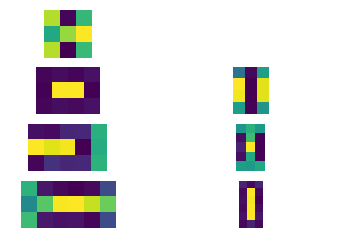


Seed = 3

Epoch 1/20
10000/10000 [==============================] - 38s 4ms/step - loss: 3.2980 - dense_1_loss: 0.9254 - dense_2h_loss: 0.6029 - dense_2v_loss: 0.7020 - dense_3h_loss: 0.3683 - dense_3v_loss: 0.3574 - dense_4h_loss: 0.1654 - dense_4v_loss: 0.1766
Epoch 2/20
10000/10000 [==============================] - 35s 4ms/step - loss: 2.0280 - dense_1_loss: 0.4812 - dense_2h_loss: 0.3475 - dense_2v_loss: 0.4862 - dense_3h_loss: 0.2444 - dense_3v_loss: 0.2394 - dense_4h_loss: 0.1150 - dense_4v_loss: 0.1142
Epoch 3/20
10000/10000 [==============================] - 35s 3ms/step - loss: 1.6856 - dense_1_loss: 0.3330 - dense_2h_loss: 0.2906 - dense_2v_loss: 0.4089 - dense_3h_loss: 0.2226 - dense_3v_loss: 0.2198 - dense_4h_loss: 0.1049 - dense_4v_loss: 0.1058
Epoch 4/20
10000/10000 [==============================] - 35s 3ms/step - loss: 1.3602 - dense_1_loss: 0.2183 - dense_2h_loss: 0.2095 - dense_2v_loss: 0.3369 - dense_3h_loss: 0.2007 - dense_3v_loss: 0.1961 - dense_4h_loss: 0.0982 -

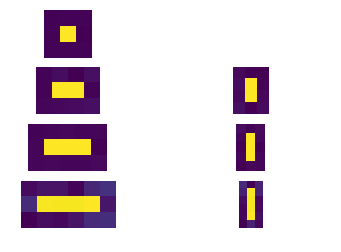

In [0]:
# Размер мини-выборки
batch_size = 1
# Количество эпох для обучения
nb_epoch = 20

# Задаем параметры оптимизации
# функция потерь mse

# sgd = SGD(lr=0.001, decay=0.000001, momentum=0.9, nesterov=True)

models = {}

for seed in range(4):
  print(f'\nSeed = {seed}\n')
  
  model_custom = create_model(seed)
  
  model_custom.compile(loss='mse',
                optimizer='adam',
                metrics=[])

  plot_conv_matrix = PlotConvCallBack()

  # подсчитываем число "правильных" кораблей (задача регрессии)

  # Обучаем модель
  history = model_custom.fit(
              X.reshape(NUM_SAMPLES,10,10,1),         
              [
                  [int(Y1[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y2h[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y2v[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y3h[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y3v[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y4h[i].sum()) for i in range(NUM_SAMPLES)],
                  [int(Y4v[i].sum()) for i in range(NUM_SAMPLES)]
              ],
              batch_size=batch_size,
              epochs=nb_epoch,
#               validation_split=0.1,
              shuffle=True,
              callbacks=[plot_conv_matrix],
              verbose=1)
  
  models[seed] = (model_custom, history)  

In [0]:
# model[3] сошлась. сохраняем

from keras.models import load_model

models[3].save('/content/best_model.hd5')

# загрузка модели
# model_count_ships = load_model('/content/sample_data/seacombat_count_deck.h5')
# model_custom.load_weights('/content/seacombat_count_ships_custom.h5')  

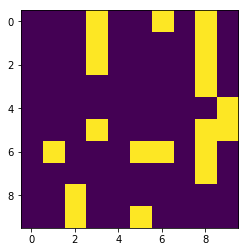

Подсчет числа кораблей на выходе нейронной сети:
[4 1 1 0 1 0 0]


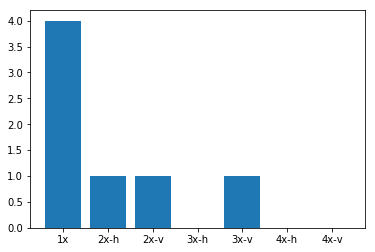

In [0]:
# пример работы модели на случайно расставленном поле

x = X[random.randint(0, NUM_SAMPLES-1)]

plt.imshow(x);
plt.show()

pred = np.round(models[3].predict(x.reshape(1,10,10,1))).reshape(7,).astype(np.int)

print('Подсчет числа кораблей на выходе нейронной сети:')
print(pred)

plt.bar(x=['1x', '2x-h', '2x-v', '3x-h', '3x-v', '4x-h', '4x-v'], height=pred)
plt.show()
